In [37]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
from plot_utils import plot_source_distributions, plot_ifa_parameters_and_ppc
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from testsuite import MAP_model, neg_log_lik

In [39]:
from tfpmodels import *
from mapper import Mapper

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

In [41]:
sess = tf.InteractiveSession()

/home/folzd/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [42]:
n_components_in_mixture = 5
n_sources = 2
n_features = 2
n_observations = 1000

In [43]:
#ifa_data = Mapper(centeredMarginalizedIndependentFactorAnalysis, 'ifa1', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*3, mixture_component_var_rate=1.*3,data_var_concentration=.1*3,data_var_rate=10.*3)
ifa_data = Mapper(mixtureOfGaussians, 'mog', observed_variable_names=['data'], n_observations=n_observations, n_components=4, n_features=n_features,mixture_component_means_var=0.1)
ifa_model = Mapper(centeredMarginalizedIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*1, mixture_component_var_rate=1.*1,data_var_concentration=.1*2,data_var_rate=10.*4)

In [44]:
generated = sess.run(ifa_data.tape)

In [45]:
#fica = FastICA(n_components=n_sources).fit(generated['data']).mixing_.T
#fica = np.concatenate([fica,np.random.randn(n_sources-n_features,n_features)],axis=0)

pca = PCA(n_components=n_sources).fit(generated['data']).components_.T
pca = np.concatenate([pca,np.random.randn(n_sources-n_features,n_features)],axis=0)

#loss, train_op = ifa_model.adam_optimizer(data=generated['data'], learning_rate=0.01)
loss, opt = ifa_model.bfgs_optimizer(data=generated['data'])
optstep = tf.contrib.opt.ScipyOptimizerInterface(loss, var_list=list(ifa_model.unconstrained_variables.values()), options={'maxiter': 1})
#loss, opt = ifa.cg_optimizer(data=generated['data'])
init_ops = []
#init_ops = [tf.global_variables_initializer()]

# Initialize in true parameters, as a sanity check
#true_parameters = dict(generated)
#true_parameters.pop('data')
#init_ops.append(ifa_model.assigner(**true_parameters))

# FastICA, large SNR, uniformish mixing weight initialization
#init_ops.append(tf.assign(ifa_model.unconstrained_variables['factor_loadings'], fica,name='initialize_directions'))
#init_ops.append(tf.assign(ifa_model.unconstrained_variables['mixture_component_var'], 10*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture),name='initialize_signal_variance'))
#init_ops.append(tf.assign(ifa_model.unconstrained_variables['data_var'], 1e-3*np.ones(ifa_model.unconstrained_variables['data_var'].shape),name='initialize_noise_variance'))
#init_ops.append(tf.assign(ifa_model.unconstrained_variables['mixture_weights'], np.ones(ifa_model.unconstrained_variables['mixture_weights'].shape)/n_components_in_mixture,name='initialize_noise_variance'))

#init_mixture_component_var = 10.*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture).astype(np.float32)
init_mixture_component_var = 10.*generated['data'].var()*np.ones((n_sources,n_components_in_mixture)).astype(np.float64)
init_data_var = 1.*np.ones(ifa_model.variable_shapes['data_var'],dtype=np.float64)
init_mixture_weights = np.ones(ifa_model.variable_shapes['mixture_weights'],dtype=np.float64)/n_components_in_mixture

init_ops.append(ifa_model.assigner(factor_loadings=pca.astype(np.float64),
                                   mixture_component_var=init_mixture_component_var,
                                   data_var=init_data_var,
                                   mixture_weights=init_mixture_weights))

#initialized_parameters = sess.run(ifa_model.variables)
#initialized_parameters.pop('sources')
#train_nll_init = neg_log_lik(initialized_parameters,centeredIndependentFactorAnalysisTest,generated['data'])
#sess.run(tf.assign(ifa_model.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))
accparams = []
learning_curve = []
def accumulate_parameters_and_loss(estimated_parameters, loss):
    accparams.append(estimated_parameters)
    learning_curve.append(loss)
sess.run(tf.global_variables_initializer())
sess.run([init_ops])
print(sess.run(ifa_model.map_neg_log_joint_fn(data=generated['data'])))

9397.075746344979


In [46]:
while True:
    try:
        opt.minimize(loss_callback=accumulate_parameters_and_loss,fetches=[ifa_model.variables, loss])
        break
    except:
        optstep.minimize(loss_callback=accumulate_parameters_and_loss,fetches=[ifa_model.variables, loss])

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 3932.989813
  Number of iterations: 132
  Number of functions evaluations: 177


In [47]:
ifa_model.variables

{'mixture_component_var': <tf.Tensor 'ifa2_1/scaled_sigmoid/forward/affine_scalar/forward/add:0' shape=(2, 5) dtype=float64>,
 'mixture_weights': <tf.Tensor 'ifa2_1/softmax_centered/forward/Softmax:0' shape=(2, 5) dtype=float64>,
 'factor_loadings': <tf.Tensor 'ifa2/factor_loadings/read:0' shape=(2, 2) dtype=float64>,
 'data_var': <tf.Tensor 'ifa2_1/scaled_sigmoid_1/forward/affine_scalar/forward/add:0' shape=(2,) dtype=float64>}

In [48]:
centeredMarginalizedIndependentFactorAnalysis

<function tfpmodels.centeredMarginalizedIndependentFactorAnalysis(n_observations=1000, n_sources=2, n_components_in_mixture=2, n_features=2, mixture_component_var_concentration=1.0, mixture_component_var_rate=1.0, mixture_weights_concentration=None, data_var_concentration=1.0, data_var_rate=1.0)>

In [49]:
ifa_model.model

<function tfpmodels.centeredMarginalizedIndependentFactorAnalysis(n_observations=1000, n_sources=2, n_components_in_mixture=2, n_features=2, mixture_component_var_concentration=1.0, mixture_component_var_rate=1.0, mixture_weights_concentration=None, data_var_concentration=1.0, data_var_rate=1.0)>

In [53]:
ifa_model._kwargs

{'n_observations': 1000,
 'n_components_in_mixture': 5,
 'n_features': 2,
 'n_sources': 2,
 'mixture_component_var_concentration': 0.1,
 'mixture_component_var_rate': 1.0,
 'data_var_concentration': 0.2,
 'data_var_rate': 40.0}

In [56]:
def replace_latents(**inferred_latent_variables):
    def interceptor(model, *args, **kwargs):
        name = kwargs.pop("name")
        for key in inferred_latent_variables:
            if name == key:
                kwargs["value"] = inferred_latent_variables[key]
        return model(*args, **kwargs)
    return interceptor

with ed.interception(replace_latents(**ifa_model.variables)):
    generator = ifa_model.model(**ifa_model._kwargs)

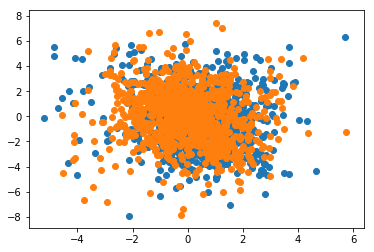

In [59]:
plt.scatter(*generated['data'].T)
plt.scatter(*sess.run(generator).T)

# ADAM training
t = []
num_epochs = 20000
sess.run(init_ops)
for i in range(num_epochs):
    sess.run(train_op)
    if i % 5 == 0:
        current_loss = sess.run(loss)
        t.append(current_loss)
plt.plot(np.arange(num_epochs,step=5)*5,t)

plot_ifa_parameters_and_ppc(sess.run(ifa_model.variables), generated, sess)

In [ ]:
learning_curve[0]

In [ ]:
plt.plot(learning_curve)
#plt.ylim([-400000,400000])

In [ ]:
testmodel = centeredMarginalizedIndependentFactorAnalysisTest(n_observations=n_observations, **ifa_model.variables)

In [ ]:
ppc = sess.run(testmodel)
plt.scatter(*ppc.T,alpha=0.1,label='test')
plt.scatter(*generated['data'].T,alpha=0.1,label='data')
plt.legend()
#plt.axis([-4,4,-4,4])

In [ ]:
plt.hist(generated['data'][:,0],'auto')
plt.hist(ppc[:,0],'auto')
plt.show()
plt.hist(generated['data'][:,1],'auto');
plt.hist(ppc[:,1],'auto');

In [ ]:
accparams[-1]